In [1]:
import sys

sys.path.append("..")

import numpy as np

import tensorflow as tf

from utils import viz_utils, eeg_utils, fmri_utils, tf_config, process_utils, preprocess_data, train, losses_utils

from models import eeg_to_fmri, classifiers

from sklearn import metrics

import matplotlib.pyplot as plt

tf_config.set_seed(seed=42)#02 20
tf_config.setup_tensorflow(device="GPU", memory_limit=1500)

dataset="11"
path_labels="../../clf_eeg/fmri_11/"
path_network="../../clf_eeg/fmri_fourier_11/"
view="fmri"

2022-03-17 11:42:14.919579: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-17 11:42:16.655153: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-17 11:42:16.655606: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-17 11:42:16.704120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 11:42:16.704845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-03-17 11:42:16.704872: I tensorflow/stream_executor/platform/def

In [2]:
epochs=10

In [4]:
def optimize_elastic(theta):
    l1_reg, l2_reg, batch_size, learning_rate = (theta)

    dataset_clf_wrapper = preprocess_data.Dataset_CLF_CV(dataset, standardize_eeg=True, load=False, load_path=path_labels)
    train_data, test_data = dataset_clf_wrapper.split(0)
    dataset_clf_wrapper.X = train_data[0]
    dataset_clf_wrapper.y = train_data[1]
    dataset_clf_wrapper.set_folds(5)

    score = 0.0
    for fold in range(5):
        print("On fold", fold+1, end="\r")
        train_data, test_data = dataset_clf_wrapper.split(fold)
        X_train, y_train=train_data
        X_test, y_test=test_data
        with tf.device('/CPU:0'):
            optimizer = tf.keras.optimizers.Adam(learning_rate)
            loss_fn=losses_utils.entropy_kl_loss
            #loss_fn=tf.keras.losses.MeanAbsoluteError()
            

            train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
            test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

            if(view=="fmri"):
                linearCLF = classifiers.view_EEG_classifier(tf.keras.models.load_model(path_network,custom_objects=eeg_to_fmri.custom_objects), 
                                                            X_train.shape[1:], activation=tf.keras.activations.relu, 
                                                            regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
            else:
                linearCLF = classifiers.LinearClassifier(regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
            linearCLF.build(X_train.shape)

        train.train(train_set, linearCLF, optimizer, loss_fn, epochs=epochs, val_set=None, u_architecture=False, verbose=True, verbose_batch=False)
        #evaluate
        linearCLF.training=False
        score+=tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_test, linearCLF(X_test)).numpy()
        print("Fold", fold+1, "with score:", tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_test, linearCLF(X_test)).numpy())
        
        print("Acc:", np.mean(((tf.keras.activations.softmax(linearCLF(X_test)).numpy()[:,1] > 0.5).astype("int32")==(y_test[:,1]).astype("int32")).astype("int32")))
        
    return score

In [5]:
#theta=(9.85296555e+00, 7.98018851e-01, int(8.00000000e+00), 1.40685660e-06)
theta=(7.98018851e-01, 7.98018851e-01, int(8.00000000e+00), 1.40685660e-06)

optimize_elastic(theta)

2022-03-17 11:42:16.827047: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-17 11:42:16.827367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-17 11:42:16.828157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-03-17 11:42:16.828195: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-17 11:42:16.828231: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-17 11:42:16.828253: I tensorflow/stream_executor/platform/

2022-03-17 11:42:19.289902: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-17 11:42:19.568845: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-03-17 11:42:19.571282: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-03-17 11:42:20.131646: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-03-17 11:42:20.161914: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Epoch 1 with loss: 0.980563186109066
Epoch 2 with loss: 0.9106964468955994
Epoch 3 with loss: 0.8892843623956045
Epoch 4 with loss: 0.8808915068705877
Epoch 5 with loss: 0.8776362140973409
Epoch 6 with loss: 0.8761582945783933
Epoch 7 with loss: 0.8750935345888138
Epoch 8 with loss: 0.8739440714319547
Epoch 9 with loss: 0.8725754196445147
Epoch 10 with loss: 0.870961052676042
Fold 1 with score: 0.9978723
Acc: 0.0
Epoch 1 with loss: 0.9611273730794588
Epoch 2 with loss: 0.8986011470357577
Epoch 3 with loss: 0.8831296861171722
Epoch 4 with loss: 0.8782504896322886
Epoch 5 with loss: 0.8769232531388601
Epoch 6 with loss: 0.8764492273330688
Epoch 7 with loss: 0.8759064922730128
Epoch 8 with loss: 0.8750618870059649
Epoch 9 with loss: 0.8739181011915207
Epoch 10 with loss: 0.8725346003969511
Fold 2 with score: 1.0138606
Acc: 0.0
Epoch 1 with loss: 0.9766961336135864
Epoch 2 with loss: 0.9233759144941965
Epoch 3 with loss: 0.9165267025430998
Epoch 4 with loss: 0.9148776903748512
Epoch 5 with

4.652536034584045

## Visualize test instance

In [6]:
l1_reg, l2_reg, batch_size, learning_rate = (theta)

dataset_clf_wrapper = preprocess_data.Dataset_CLF_CV(dataset, standardize_eeg=True, load=False, load_path=path_labels)
train_data, test_data = dataset_clf_wrapper.split(0)

X_train, y_train=train_data
X_test, y_test=test_data


with tf.device('/CPU:0'):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn=losses_utils.entropy_kl_loss
    #loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #loss_fn=tf.keras.losses.MeanAbsoluteError()

    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)

    if(view=="fmri"):
        linearCLF = classifiers.view_EEG_classifier(tf.keras.models.load_model(path_network,custom_objects=eeg_to_fmri.custom_objects), 
                                                    X_train.shape[1:], activation=tf.keras.activations.relu, 
                                                    regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
    else:
        linearCLF = classifiers.LinearClassifier(regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg))
    linearCLF.build(X_train.shape)

train.train(train_set, linearCLF, optimizer, loss_fn, epochs=epochs, val_set=None, u_architecture=False, verbose=True, verbose_batch=False)
linearCLF.training=False
print((tf.keras.activations.softmax(linearCLF(X_test)).numpy()[:,1] > 0.5).astype("int32"))

Epoch 1 with loss: 1.004304426908493
Epoch 2 with loss: 0.9341300129890442
Epoch 3 with loss: 0.9260881702105205
Epoch 4 with loss: 0.9256907383600871
Epoch 5 with loss: 0.9263996263345082
Epoch 6 with loss: 0.9266723434130351
Epoch 7 with loss: 0.9262921373049419
Epoch 8 with loss: 0.9253714084625244
Epoch 9 with loss: 0.9240628441174825
Epoch 10 with loss: 0.9224818368752797
[1 1 1 1 1 1 0 1]


In [7]:
dev_views = np.empty((0,)+getattr(fmri_utils, "fmri_shape_01")+(1,))
for x, _ in test_set.repeat(1):
    dev_views = np.append(dev_views, linearCLF.view.q_decoder(x), axis=0)
dev_views_set = tf.data.Dataset.from_tensor_slices((dev_views,y_test)).batch(1)

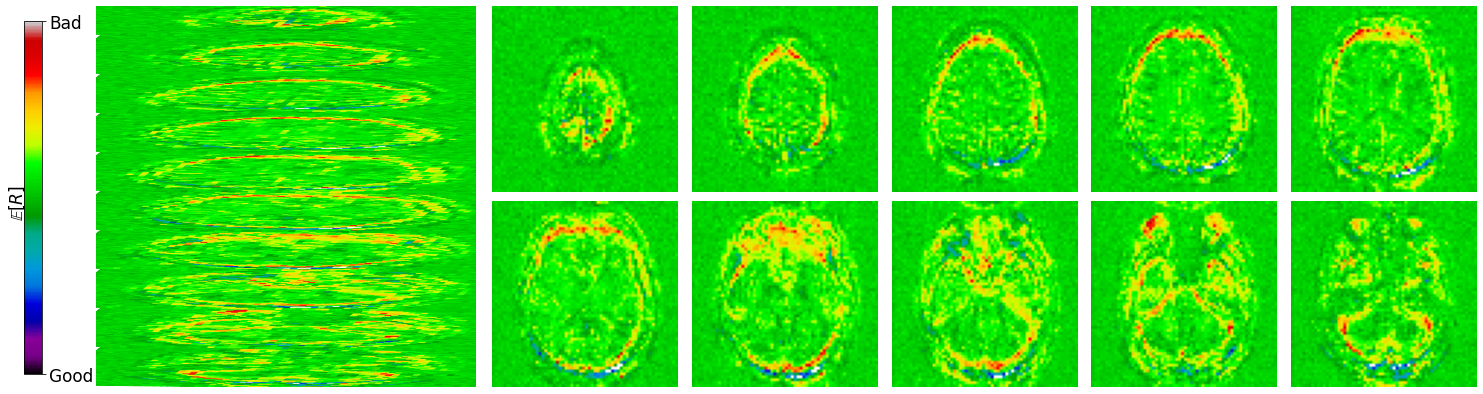

In [8]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(dev_views,axis=0),
                                                        slice_label=False,
                                                        uncertainty=False,
                                                        threshold=0.2,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,)# save_path=path+"/explainability/fmri_E_R.pdf",

## Compute AUC

In [9]:
y_pred = tf.keras.activations.softmax(linearCLF(X_train)).numpy()[:,1]
y_true = y_train[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.9147222222222222

In [10]:
y_pred = tf.keras.activations.softmax(linearCLF(X_test)).numpy()[:,1]
y_true = y_test[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

/home/ist_davidcalhas/anaconda3/envs/eeg_fmri/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


nan

In [11]:
y_pred

array([0.5137004 , 0.5103234 , 0.50924295, 0.505891  , 0.5047739 ,
       0.50692075, 0.49352378, 0.5085303 ], dtype=float32)

In [12]:
(y_pred>0.5).astype("int32")

array([1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

In [13]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
np.mean(((y_pred>0.5).astype("int32")==y_true).astype("int32"))

0.125

## LRP Explaining Pathology

In [15]:
from utils import lrp

In [16]:
### Compute fMRI views
train_pathology_views = np.empty((0,)+getattr(fmri_utils, "fmri_shape_01")+(1,))
for x, y in train_set.repeat(1):
    if(np.all(y[:,1] == 1.)):
        train_pathology_views = np.append(train_pathology_views, linearCLF.view(x)[0], axis=0)
train_pathology_views_set = tf.data.Dataset.from_tensor_slices((train_pathology_views,np.ones(len(np.where(y_train==[1.,0.])[0])//2))).batch(1)

train_healthy_views = np.empty((0,)+getattr(fmri_utils, "fmri_shape_01")+(1,))
for x, y in train_set.repeat(1):
    if(np.all(y[:,1] == 0.)):
        train_healthy_views = np.append(train_healthy_views, linearCLF.view(x)[0], axis=0)
train_healthy_views_set = tf.data.Dataset.from_tensor_slices((train_healthy_views,np.zeros(len(np.where(y_train==[0.,1.])[0])//2))).batch(1)

In [17]:
explainer = lrp.LRP(linearCLF.clf)
R_pathology=lrp.explain(explainer, train_pathology_views_set, eeg=True, fmri=False, verbose=True)

In [18]:
R_healthy=lrp.explain(explainer, train_healthy_views_set, eeg=True, fmri=False, verbose=True)

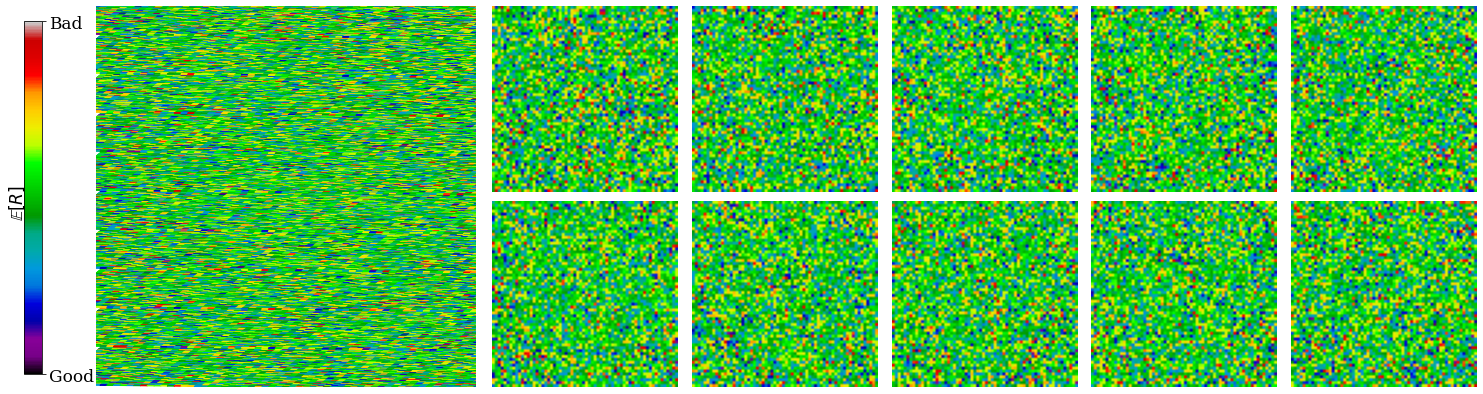

In [19]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(R_pathology,axis=0),
                                                        slice_label=False,
                                                        uncertainty=False,
                                                        threshold=-10,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,)# save_path=path+"/explainability/fmri_E_R.pdf",

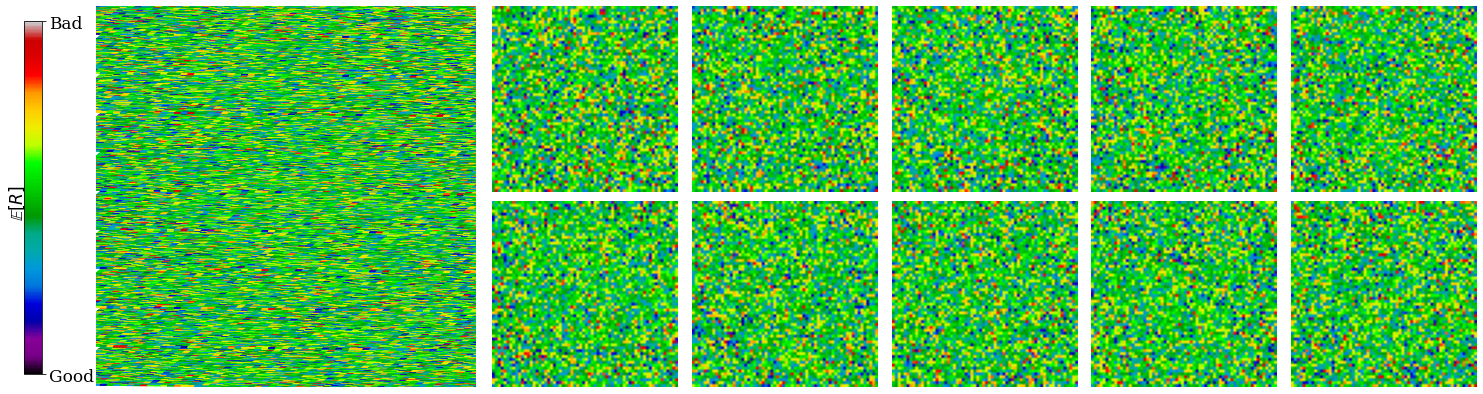

In [20]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(R_healthy,axis=0),
                                                        slice_label=False,
                                                        uncertainty=False,
                                                        threshold=-10,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False,)# save_path=path+"/explainability/fmri_E_R.pdf",

In [25]:
linearCLF.view(X_test)[0].numpy().shape

(8, 64, 64, 30, 1)